In [1]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd 

from sklearn import metrics
from sklearn.model_selection import train_test_split

import timm
import albumentations

from torchret import Model 

/Users/parth/miniconda3/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
configs = {
    'epochs' : 10,
    'lr' : 1e-4,
    'eta_min' : 1e-6,
    'T_0' : 10,
    'epochs' : 10,
    'step_scheduler_after' : 'epoch',

    'train_bs' : 64,
    'valid_bs' : 64,

    'num_workers' : 0,
    'pin_memory' : False,

    'model_name' : 'resnet10t',
    'pretrained' : True,
    'num_classes' : 10,
    'in_channels' : 1,
    'device' : 'mps',

    'model_path' : 'digit-recognizer.pt',
    'save_best_model' : 'on_eval_metric',
    'save_on_metric' : 'accuracy',
    'save_model_at_every_epoch' : False,

}

In [3]:
class DigitRecognizerDataset:
    def __init__(self, df, augmentations):
        self.df = df
        self.targets = df.label.values
        self.df = self.df.drop(columns=["label"])
        self.augmentations = augmentations

        self.images = self.df.to_numpy(dtype=np.float32).reshape((-1, 28, 28))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        targets = self.targets[item]
        image = self.images[item]
        image = np.expand_dims(image, axis=0)

        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [4]:
train_augs = albumentations.Compose(
        [
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0,
            ),
        ],
        p=1.0,
    )

valid_augs = albumentations.Compose(
        [
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0,
            ),
        ],
        p=1.0,
    )

In [5]:
df = pd.read_csv('train.csv')
train, test = train_test_split(df, test_size=0.2)

train_dataset = DigitRecognizerDataset(df = train, augmentations = train_augs)
valid_dataset = DigitRecognizerDataset(df = test, augmentations = valid_augs)

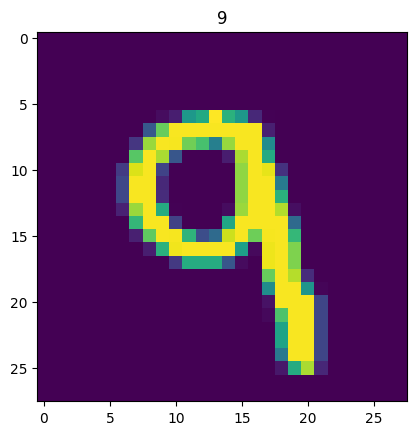

In [13]:
import matplotlib.pyplot as plt 
data = train_dataset[789]

plt.imshow(data['images'].permute(1, 2, 0))
plt.title(data['targets'].item());

In [14]:
class DigitRecognizerModel(Model):
    def __init__(self):
        super().__init__()

        self.model = timm.create_model(
            model_name = configs['model_name'],
            pretrained=configs['pretrained'],
            in_chans=configs['in_channels'],
            num_classes=configs['num_classes'],
        )

        self.num_workers = configs['num_workers']
        self.pin_memory = configs['pin_memory']
        self.step_scheduler_after = configs['step_scheduler_after']

        self.model_path = configs['model_path']
        self.save_best_model = configs['save_best_model']
        self.save_on_metric = configs['save_on_metric']
        self.save_model_at_every_epoch = configs['save_model_at_every_epoch']

    def monitor_metrics(self, outputs, targets):
        device = targets.device.type
        outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
        targets = targets.cpu().detach().numpy()
        acc = metrics.accuracy_score(targets, outputs)
        acc = torch.tensor(acc, device=device)
        return {"accuracy": acc}
    
    def monitor_loss(self, outputs, targets):
        loss = nn.CrossEntropyLoss()(outputs, targets)
        return loss

    def fetch_optimizer(self):
        opt = torch.optim.SGD(
            self.parameters(),
            lr=configs['lr'],
            momentum=0.9,
        )
        sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            opt, 
            T_0 = configs['T_0'],
            eta_min = configs['eta_min'],
            T_mult= 1
        )
        return opt, sch

    def forward(self, images, targets=None):
        x = self.model(images)
        if targets is not None:
            loss = self.monitor_loss(x, targets)
            metrics = self.monitor_metrics(x, targets)
            return x, loss, metrics
        return x, 0, {}

In [15]:
model = DigitRecognizerModel()
model.fit(train_dataset, valid_dataset, device = configs['device'], epochs = configs['epochs'])

100%|██████████| 132/132 [00:50<00:00,  2.62it/s, accuracy=0.79, epoch=1, loss=0.732165, stage=eval] 


Model Saved at digit-recognizer.pt
Model was saved based on_eval_metric with 0.7895359848484849 accuracy


100%|██████████| 132/132 [00:47<00:00,  2.76it/s, accuracy=0.888, epoch=2, loss=0.401655, stage=eval]


Model Saved at digit-recognizer.pt
Model was saved based on_eval_metric with 0.8884943181818182 accuracy


100%|██████████| 132/132 [00:51<00:00,  2.55it/s, accuracy=0.917, epoch=3, loss=0.289783, stage=eval]


Model Saved at digit-recognizer.pt
Model was saved based on_eval_metric with 0.9166666666666666 accuracy


100%|██████████| 132/132 [00:48<00:00,  2.70it/s, accuracy=0.929, epoch=4, loss=0.242547, stage=eval]


Model Saved at digit-recognizer.pt
Model was saved based on_eval_metric with 0.9294507575757576 accuracy


100%|██████████| 132/132 [00:57<00:00,  2.31it/s, accuracy=0.941, epoch=5, loss=0.208137, stage=eval]


Model Saved at digit-recognizer.pt
Model was saved based on_eval_metric with 0.9408143939393939 accuracy


100%|██████████| 132/132 [00:45<00:00,  2.88it/s, accuracy=0.944, epoch=6, loss=0.192414, stage=eval]


Model Saved at digit-recognizer.pt
Model was saved based on_eval_metric with 0.9442471590909091 accuracy


100%|██████████| 132/132 [00:45<00:00,  2.91it/s, accuracy=0.949, epoch=7, loss=0.182296, stage=eval]


Model Saved at digit-recognizer.pt
Model was saved based on_eval_metric with 0.9485085227272727 accuracy


100%|██████████| 132/132 [00:51<00:00,  2.58it/s, accuracy=0.949, epoch=9, loss=0.176568, stage=eval]


Model Saved at digit-recognizer.pt
Model was saved based on_eval_metric with 0.9491003787878788 accuracy


100%|██████████| 132/132 [00:48<00:00,  2.70it/s, accuracy=0.947, epoch=10, loss=0.176467, stage=eval]
